# Day 1 of AI Academy 2022 - NLP Track

Hi There! Welcome to day 1 lab in your AI Academy 2022 program, NLP track. In this lab, we'll go through the process of exploratory data analysis and building a baseline model. In the end of our lab, there will be some exercise that should help move towards your final project and will help you deepen your understanding of the material. Before we start hacking away, let's have a quick reminder of the business usecase we're trying to solve.


<a target="_blank" href="https://colab.research.google.com/github/Mostafa-Samir/AI-Academy-NLP-Dec-2022/blob/main/Day-1-lab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Colab Configuration

If you chose to run in Colab, you'll need to run the following cell. 

_**DO NOT RUN THE NEXT CELL IF YOU'RE RUNNING THE NOTEBOOK LOCALLY!**_

In [ ]:
# !git clone https://github.com/Mostafa-Samir/AI-Academy-NLP-Dec-2022.git

# !cd AI-Academy-NLP-Dec-2022 && \
#  pip install --upgrade pip && \
#  pip install -r requirements.txt && \
#  python -m setup-nltk

## Data Path Resolution

There'll be a slight difference in the file structure if you chose to run this notebook in Colab compared to running locally. The following script will take into account this difference in file structure to make sure sure that pathes to the data are correct in the rest of the notebook. The script will define a `DATA_ROOT` under which calling `DATA_ROOT/data/english/train.csv` for example will always be resolved correctly regardless of the environemnt.

In [4]:
running_in_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
DATA_ROOT = "./AI-Academy-NLP-Dec-2022" if running_in_colab else "."


## Quick Recap of the Use Case
A compay called **Super Fast Telecom Solutions**, which operates mobile and internet networks, has approached us with a problem. Their problem is that a lot of theri customers are tweeting about their services and the issues they face with it and customer support representatives are not fast enough to go through the tweets, identify the ones reposrting an issue in order to communicate with the customers and solve their issues. To make things faster, they need a way to quickly flag tweets that contain a problem or a negative opinion about their services and priortrize them so that they can be addressed quickly. They want to build a **brand monitoring** application that would allow them to:
1. Identify tweets with negative sentiment and flag them for quick response from the custome service representative.
2. Review the overall sentiment about their services across time.

Before sharing the data they have with you, Super Fast Teelcom Solutions requested that we show them a PoC of a sentiment analysis model that would be the core AI feature in such a brand monitoring system. They however shared other tweets data, unrelated to their brand, that should be similar in distribution to their brabnd-related data.

The syetem they desire should be bi-lingual (supporting both English and Arabic), and they shared data in both languages and they are provide under the `data` directory in this repository. For each language, we're given three CSV files:
- `train.csv` for the training data
- `dev.csv` for data to be used in model development (e.g. hyper-parameters tuning)
- `test.csv` to test our models against.

## Step 1: Exploratory Data Analysis (EDA)
The very first step in our process would be to look into the data itself and explore its different aspects and charactristics in order to build a suitable model. In exploratory data analysis, or EDA for short, we try to probe into the data and answer some specific questions like:
- How much data do we have?
- What is the distribution of the classes? is the data blanced or skewed twoards a specific class?
- How long is the tweets? does that differ from one class to another?
- What are the most common words, and what are the least common words? What about per class?
- How much unique vocabulary is there? What is the most informative?

Answering these questions and more would guide us to towards building a more suitable model for the data we have; should we try to fix the imbalance in the data? what kind of preocessing do we need to do in order to make the problem more approachable? what is the best metric to track in our experiments? ... etc.

### Class Exploration
Our first exploration would be into the classess associated with the data we have: how many are they? and what's their distribution. Let's first take a look at the head of our data and understand how the CSV files are formatted.

In [5]:
import pandas as pd
import os

english_training_data = pd.read_csv(os.path.join(DATA_ROOT, "data/english/train.csv"))
english_training_data.head(3)

,tweet,label
0,This time tomorrow\u002c @quinnjessica and I w...,negative
1,@cassiehendrix are you in the land of my fathe...,neutral
2,False start penalty\u002c Garner moved early. ...,negative


We can see from the output above is that our data is formatted into two cloumns: one called `tweet` and contains the tweet text itself, and the other called `lable` and holds the designated sentiment of the tweet. We can see two distinct labels in the sample above: `neutral` and `negative`, but that doens't mean that the whole data set contains these two labels. To get all the distinct labels in the data, we utilize the `unique` method in `pandas` as follows.

In [6]:
english_training_data.loc[:, "label"].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

What we did above is that we selected all the rows in our dataframe, and only the column called `label`, then the unique method reported to us another label in addition to the two we observed above, the `positive` label. It's safe to assume now that our data come with three classes: `poitive` indicating tweets that hold a postive opinion or sentiment, `negative` for the negative ones, and `neutral` for the tweets that do not have any sentiment or opinionated views. The question now is how are these three classes distributed?

To answer this question, we'll utilize `seaborn` as a visualization package to give us a bar plot indicating the counts of the samples for each of the three classes, as well as the `groupby` feature from pandas to look at the prcises counts for each class. 

negative: 429 samples
neutral: 202 samples
positive: 613 samples


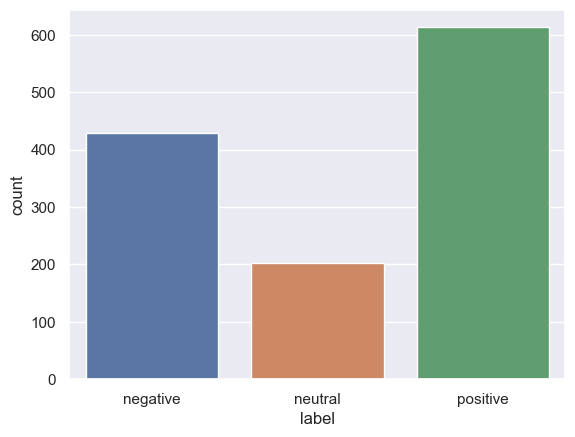

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.countplot(data=english_training_data, x="label")

classes_groups = english_training_data.groupby("label")
for group_key, group_df in classes_groups:
    print(f"{group_key}: {len(group_df)} samples")

As we can see from the samples count above and the count plot, our data is imabalnced, with the majority of data being on the positive side of sentiments. This observation should make us think about what is the metric that we should use to evaluate the models that we're going to build.

_**Discussion Question: refer back to the metrics we discussed in the morning (accuracy, f1-score and its variants), what is the best metric to use here, and why? (keep in mind the business requirement of the project while you think of an answer)**_

_..._

Another thing that we notice form that exercise, beside the class imbalance, is that we only have 1244 training samples, which is not much and this will require us to think about models that are sample effcient in order to learn something for such a relatively small data set.

---

### Length Exploration

The next thing we can look at is how long is our text. We can do so by applying a function along the tweets column that tockenizes the tweet by whitespaces and reports the length of the tokens list. We can run the `describe` method from `pandas` from the output of the applied function and get various descrtiptive statistics about the obverall lengths of the tweets. We choose to report the minimum length, maximum length, and the mean with standrad deviation. We also use the `histplot` from `seaborn` to render a histogram of the tweet lengthes that would give us more visibility into the distribution of the lengthes.

Overall Tweets Length
	Min = 5.0, Max = 35.0
Mean ± std: 20.9 ± 5.0


<AxesSubplot: xlabel='tweet_lengths', ylabel='Count'>

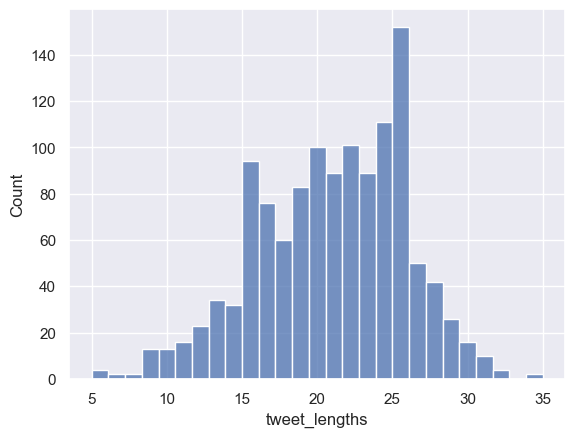

In [8]:
tweet_lengths = english_training_data.loc[:, "tweet"].apply(lambda tweet: len(tweet.split(" ")))
tweet_lengths.name = "tweet_lengths"

tweet_length_stats = tweet_lengths.describe()
print("Overall Tweets Length")
print(f"\tMin = {tweet_length_stats['min']}, Max = {tweet_length_stats['max']}")
print(f"Mean ± std: {tweet_length_stats['mean']:.1f} ± {tweet_length_stats['std']:.1f}")

sns.histplot(tweet_lengths)

_**Exercise: Run the same length exploration as above but on each individual class in the data.**_

In [ ]:
# Write your solution here

As we can see from the results above, the length of the tweets (in terms of words) is around 20 words per sampple, which is good news for the sequence based models we can use (like recurrent neural network and transfromers) because it means that we can process these tweets with a samll computational footprint.

---

### Vocabulary analysis

The last kind of exploratory analysis we'll do here is the vocabulary analysis. With this analysis, we shed some light on the necessary preprocessing we need to carry out on the data before we can train any model. We do our vocabulary analysis by looping through the tweets we have and tokenize them and count the occurance of each word in a dictionary. We then use this dictionary to get the 100 most common and the least common words in the dataset and plot in a bar plot fashion. We'll wrap this logic in a function called `analyze_vocabulary` in order to reuse the same logic when we explore data cleaning pipeline in the next step.

Number of Unique Tokens: 8536


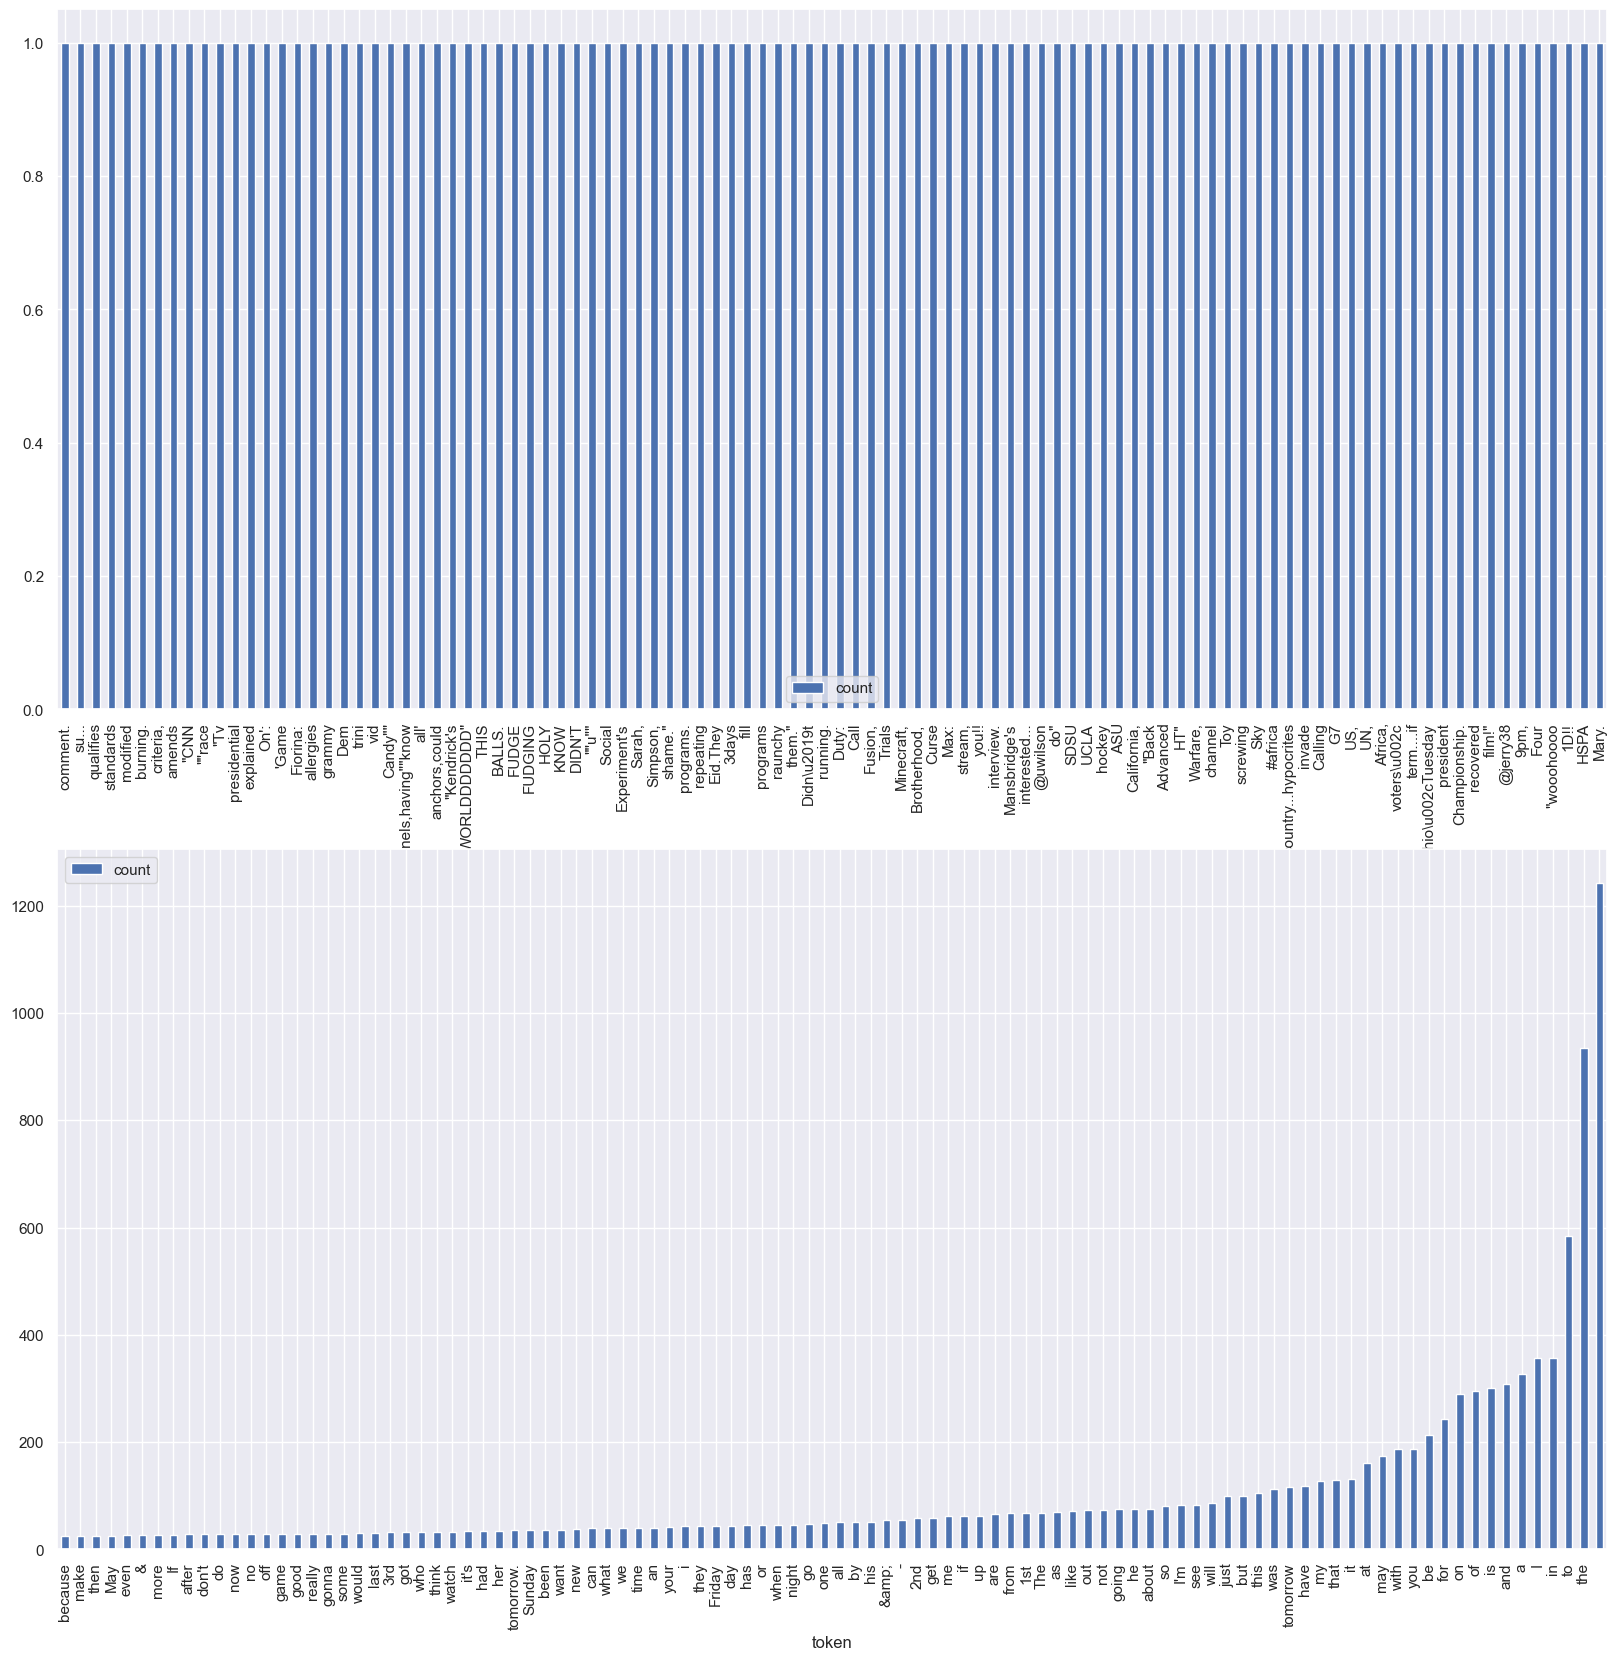

In [10]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
def analyze_vocabulary(df: pd.DataFrame):
    word_count = defaultdict(int)
    _, axes = plt.subplots(2, 1, figsize=(20, 20))

    for i, row in df.iterrows():
        tweet = row["tweet"]
        tokens = tweet.split(" ")
        for token in tokens:
            if token:  # ignore empty strings
                word_count[token] += 1

    unique_tokens = list(word_count.keys())
    unique_tokens_count = list(word_count.values())

    sorted_token_indecies = np.argsort(unique_tokens_count)
    least_100_frequent_tokens_indecies = sorted_token_indecies[:100]
    most_100_frequent_tokens_indecies = sorted_token_indecies[-100:]

    least_100_frequent_tokens = [unique_tokens[i] for i in least_100_frequent_tokens_indecies]
    least_100_frequent_tokens_counts = [unique_tokens_count[i] for i in least_100_frequent_tokens_indecies]
    most_100_frequent_tokens = [unique_tokens[i] for i in most_100_frequent_tokens_indecies]
    most_100_frequent_tokens_counts = [unique_tokens_count[i] for i in most_100_frequent_tokens_indecies]

    pd.DataFrame({"token": least_100_frequent_tokens, "count": least_100_frequent_tokens_counts}).plot.bar(x="token", y="count", ax=axes[0])
    pd.DataFrame({"token": most_100_frequent_tokens, "count": most_100_frequent_tokens_counts}).plot.bar(x="token", y="count", ax=axes[1])

    print(f"Number of Unique Tokens: {len(unique_tokens)}")

    return word_count

_ = analyze_vocabulary(english_training_data)

As we can see from the analysis above, we have around 9k unique words in the data, this number could be challangeing for vocabulary-based modeling approaches (like Bag of words and TFIDF) especially withe the low number of samples we have in the dataset. However, if we looked at the plots above, we can see lots of capitalized words and words precedded with quotes and double qoutes, we can aslo see user mentions (makes sense given that we're daeling with tweets). All these observations suggest that some cleaning approaches and preprocessing on the data would take down the number of unique vocabulary considerably and make the problem more tractable.


## Step 2: Data Cleaning and Preprocessing

As we have observed in the exploratory analysis of the vocabulary, there seems to be a potential to redcue the number of unique tokens in the data by doing some data cleaning and preprocessing before we start any kind of modeling. The first two things we can think about doing is to:
1. Remove punctuation characters except for # (indicating a hashtag) and @ (indicating a user mention)
2. Convert all text to lower case

Before we write the actual cleaning steps though, we will define first a helper function called `pipeline`. The purpose of this function is to introduce chaining between cleaning steps so that our cleaning pipeline cna be modular and can be edited on the fly by removing/adding steps without huge changes in the code.

In [ ]:
def pipeline(fn_list):
    def inner_function(text):
        out = text
        for fn in fn_list:
            out = fn(out)
        return out
    
    return inner_function

In [ ]:
from string import punctuation

def remove_punctuations(text: str) -> str:
    reduced_punctuation = punctuation.replace("#", '')
    reduced_punctuation = reduced_punctuation.replace("@", '')
    clean_text = text.translate(str.maketrans('', '', reduced_punctuation))

    return clean_text

def lower_text(text: str) -> str:
    return text.lower()

In [ ]:
cleaned_english_training_data = english_training_data.copy()
cleaned_english_training_data.loc[:, "tweet"] = cleaned_english_training_data.loc[:, "tweet"].apply(
    pipeline([remove_punctuations, lower_text])
)

word_counts = analyze_vocabulary(cleaned_english_training_data)

By doing these simple cleaning steps, we were able to chop off almost 2.5K words from the unique vocabulary. If we looked at the new graphs above, we can see that the 100 least common words have a lot of user mentions. We don't think that the specifc handle mentioned in the tweet would be contributing much into the sentiment of the tweet itself, so in order to reduce the vocabulary and the noise in the data even more, we'll normalize all the user mentions to a generic `@user` token. We'll define a new function to do such normalization and add it to our cleaning pipeline. We'll be utilizing regular expressions to do that cleanly without the need to tokenize the text and loop through it.

In [ ]:
import re

def normalize_mentions(text: str) -> str:
    return re.sub("@\w*", "@user", text)

In [ ]:
cleaned_english_training_data = english_training_data.copy()
cleaned_english_training_data.loc[:, "tweet"] = cleaned_english_training_data.loc[:, "tweet"].apply(
    pipeline([remove_punctuations, lower_text, normalize_mentions])
)

word_counts = analyze_vocabulary(cleaned_english_training_data)

Now we move our attention to the 100 most common words, the first striking observation we see is that the most common word seems to be empty; there's no word written below it. To understand what's going on here, we need to look directly into the word instead of looking at it in the graph. To do so, we utilize the counts dictionary returned form `analyze_vocabulary` and directly check what is that most common word.

In [ ]:
unique_words = list(word_counts.keys())
counts = list(word_counts.values())

most_common_word_index = np.argmax(counts)
unique_words[most_common_word_index]

We can see the most common word is just the newline character, this will probably not hold any informatrion with respect to our classification task, so we should include a step in our pipeline to remove it. Moreover, we can see in the most common tokens some words like _the_, _a_, _and_, _is_, ... etc. These words are usually called stopwords and they contribute nothing to the prediction tasks on the text. We'll utilize the `nltk` package (whic contains stopwords lists for multiple languages) to remove these stopwords from the tweets.

In [ ]:
from nltk.corpus import stopwords

def remove_newlines(text: str) -> str:
    return text.replace("\n", '')

def remove_stopwords(text: str) -> str:
    en_stopwords = set(stopwords.words("english"))
    return " ".join([word for word in text.split(" ") if word not in en_stopwords])

In [ ]:
cleaned_english_training_data = english_training_data.copy()
cleaned_english_training_data.loc[:, "tweet"] = cleaned_english_training_data.loc[:, "tweet"].apply(
    pipeline([remove_stopwords, remove_newlines, remove_punctuations, lower_text, normalize_mentions, remove_stopwords])
)
# Why do you think `remove_stopwords` is added twice in the pipeline?

word_counts = analyze_vocabulary(cleaned_english_training_data)

_**Exercise: Using the cleaned data, conduct the vocabulary analysis on the positive and negative tweets seprately. What do you observe? One thing to look at is the words that are in the negative vocabulary but not in the positive vocabulary (and vice-versa), also their intersection.**_

In [ ]:
# Write your solution here

## Step 3: Baseline

Now, we're in a state where we can start building a baseline model to predict the sentiment of a given tweet. As you may already now, all machine learning models need a way to represent the predictors as features. In NLP applications, we usually work with what is called a **Vector Space Model**, where our text is represented as a vector (or a list) of numerical values. There are several ways to do so, and we'll start today with the simplest, yet effective, form of vector space models.

### Bag of Words Representation

The bag of words (as the name suggests) treats a text as a bag containing some words. For example the sentence _"the cat in the hat is on the mat"_ can be viewed as a bag containing: 1 _cat_, 1 _hat_, 1 _mat_, 1 _in_, 1 _is_, 1 _on_, 3 _the_, and 0 _any other word_. More generally, if we have V unqiue words in our vocabulary, a bag of words vector representation of some text is a vector $w \in \mathbb{N}^V$ such that each element of the vector $w_i$ is how many times word $i$ has occurred in the text. Scikit-learn provides a very convinent transformer to featurize our text as a bag of words vectors, but before we use that, we'll first need to load our testing data and subject it to the same cleaning pipeline we used for our training data.

In [ ]:
english_testing_data = pd.read_csv("data/english/test.csv")
cleaned_english_testing_data = english_testing_data.copy()
cleaned_english_testing_data.loc[:, "tweet"] = cleaned_english_testing_data.loc[:, "tweet"].apply(
    pipeline([remove_stopwords, remove_newlines, remove_punctuations, lower_text, normalize_mentions, remove_stopwords])
)

We can now start using the bag of words representation via scikit-learn's `CountVectorizer`. Remember that we'll be fitting that vectorizer on the training set only and then used the fitted vectorizer to transform the testing set. Fitting a vectorizer is simply the process of identifying the unique vocabulary and assigning each word a unique index. There are more operations and configurations that can be tweaked, but that's mainly the fitting logic.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(cleaned_english_training_data.loc[:, "tweet"])
X_test = vectorizer.transform(cleaned_english_testing_data.loc[:, "tweet"])

Now that we have our textual data properly vectorized, we can start using a machine learning model to start predicting the sentiment of the model. Our baseline model that we'll be using is a naive Bayes Classifier. If you don't aleady know what that is, it's simply a classifier based on Bayes theorem from probability that assumes independence between the features. So in our bag-of-words representation, the classifer will model the probability of a the whole text being in a specific class as the product of each of the individual words occurences being in that class, or:

$$
P(C=c|w) = P(C=c|w_0) \times  P(C=c|w_1) \times ... \times  P(C=c|w_V)
$$

Each individual probability in that product is calculated using the Bayes rule as:

$$
P(C=c|w_i) = \frac{P(w_i|C=c)P(C=c)}{P(w_i)}
$$

In [ ]:
from sklearn.naive_bayes import MultinomialNB

y_train = cleaned_english_training_data.loc[:, "label"]
y_test = cleaned_english_testing_data.loc[:, "label"]

clf = MultinomialNB()
clf.fit(X_train, y_train)

Now that our model is trained, we test it against the testing data to see its performance. As per our discussion earlier, we're inetersted to see the weighted F1 score as our metric, as well as the individual F1-score for each label, to get all these metrics at once, we'll use scikit-learn's `classifcation_report`.

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

As we can see in the result above, the overall weighted F1-score is 55%, and the F1-score for the positive class is much higher than the one for the neagtive class. This is a natural consequence of the data imbalance we noticed before, where there are more positive data than there are negative and neutral (the bad performnace is easily noticablle in the neutral case). Handle such class imbalance is a full course of its own; there are different approaches in different levels of the process (data sugmentation, resampling, cost-rewighting ... etc), we'll only consider one improvement we can do with our current classifier which falls under the "cost-rewighting" umbrella (although it's not related to a specific cost function). If you remember from the formula of the Bayes classifier above, there is a term from the probability of the class itself $P(C=c)$. This term is called the _prior_  and it's computed from the data itself and it will refelect the imbalance we see in the data. However, we can skip calculating this prior from the data and insert our own distribution to control the behavior of the classifier. For example, we can say that the prior distribution is 50% for negative label and 25% for each of the positive and neutral labels. This way, we tell the classifier that we need more emphasis on the neagtive class in comparison to the other two classes (we also put higher importance on the neutral class this way and lower importance on the positive class)

In [ ]:
rewieghted_clf = MultinomialNB(class_prior=np.array([0.5, 0.25, 0.25]))
rewieghted_clf.fit(X_train, y_train)

y_pred = rewieghted_clf.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred))

By this simple re-weighting, we are able to increase the F1-score for the negative class by 3% and improve its recall by 20%. We did lose some precision because more non-negatives are being labeled as negative, but that's not a problem in our use case. Something positive being labeled as negative in our system won't be a problem because the customer service representatives can simply ignore it, while missing a truely negative tweet altogether is problematic. That's why the increase in recall outweighs the reduction in precision.

We can also see that the F1-score for neutral increased by 12% and the F1-score of the postivie class was reduced by 7%. However, the overall weighted F1-score was only reduced by 1% while attaining much better perfromance for the negative class, which is our main focus. We'll end our day now by saving thse classifier to disk in order to use them later for deployment if needed.

In [ ]:
import joblib

joblib.dump(vectorizer, "vectorizer.bin")
joblib.dump(clf, "classifier.bin")

## Open-ended Exercises

**In this exercise, you're asked to try and enhance of the performance of the baseline we provide above. There are several dimesnions that you and your team can work along:**
- **_Data Preprocessing_: can you decrease the vocabulary size even more? Think of using lemmatization or stemming using a package like `spacy`, how does that affect your models?**
- **_Faeture Extraction_: there are two things we can try here**
    - **_Using a different Vector Reprsentation_: like term ferquency, inverse document frequency (tfidf).**
    - **_Playing withe vectorizer parameters_: espcially the `ngram_range`, which can be used to consider a vocabulary of two or more words instead of single workld vocabulary (more words could equal more context representation). Another interesting parameters is the `analyzer` which you can use along with `ngram_range` to use a vocabulary on the character level instead of the word-level (that could benefcial with morpholgically complex language like arabic)**
- **_Different ML Algorithms_: we only used naive Bayes here, but there are more models to try, like logistic regression, support vector machines, ... etc. (no neural networks for now though)**

**An improvment on the baseline would likely be due to changes on more than one of these dimesnions or other dimensions that you can think of.**

**Scikit-learn documentation should be your friend and companion while attempting this exercise**